# Hackerearth--Novartis-Competition
In this competition hosted on Hackerearth website Novartis is challenging us to predict if the server will be hacked or not. We are given data with columns :

1. Incident Id : Unique identifier of the incident log
2. Date : Date of incident occurence
3. X_1 - X_15 : 15 anonymized columns having logging parameters
4. Multiple_offense : Target column : 1 for a hack and 0 for no

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Stats
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
%matplotlib inline

In [2]:
# Importing all the given datasets to pandas dataframes
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Parsing the date column as 'date' datatype in both training and test data
train['DATE'] = pd.to_datetime(train['DATE'])
test['DATE'] = pd.to_datetime(test['DATE'])

sub = pd.read_csv("sample_submission.csv")

# Exploratory data analysis

In [3]:
# Checking the training data
train.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,2004-07-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,2017-07-18,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,2017-03-15,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,2009-02-13,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,2005-04-13,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


From the initial look we can see that all the encrypted values are numerical values, we may need to further check if some columns are categorical and are encoded to numerical values.<br>

Also only variable X_12 is float whereas all other features are integers

In [4]:
train.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
count,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23674.000000,23856.000000,23856.000000,23856.000000,23856.000000
mean,0.483778,24.791206,24.637450,4.276744,2.455609,6.154175,4.876509,0.972460,4.924128,1.244802,206.954519,0.974064,85.237383,72.674296,33.464747,0.955231
std,1.439738,15.240231,15.135093,2.944672,1.963095,4.471756,3.881931,1.453144,1.362625,1.119301,93.033348,1.167725,27.597226,43.297320,8.386834,0.206800
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.000000,8.000000,2.000000,1.000000,3.000000,2.000000,0.000000,5.000000,1.000000,174.000000,1.000000,72.000000,29.000000,34.000000,1.000000
50%,0.000000,24.000000,24.000000,4.000000,3.000000,5.000000,4.000000,1.000000,5.000000,1.000000,249.000000,1.000000,98.000000,62.000000,34.000000,1.000000
75%,0.000000,36.000000,35.000000,6.000000,5.000000,8.000000,7.000000,1.000000,6.000000,1.000000,249.000000,1.000000,103.000000,107.000000,34.000000,1.000000
max,7.000000,52.000000,52.000000,10.000000,5.000000,19.000000,18.000000,99.000000,6.000000,90.000000,332.000000,90.000000,116.000000,142.000000,50.000000,1.000000


## Checking the null values in the data

In [5]:
train.isna().sum().sort_values(ascending = False)

X_12                182
MULTIPLE_OFFENSE      0
X_6                   0
DATE                  0
X_1                   0
X_2                   0
X_3                   0
X_4                   0
X_5                   0
X_7                   0
X_15                  0
X_8                   0
X_9                   0
X_10                  0
X_11                  0
X_13                  0
X_14                  0
INCIDENT_ID           0
dtype: int64

Variable X_12 is the only feature having null values present in the data, lets check the values in X_12 variable

In [6]:
train['X_12'].value_counts()

1.0     15674
0.0      5171
2.0      2039
3.0       476
4.0       176
5.0        59
6.0        36
8.0         9
10.0        7
9.0         6
7.0         4
11.0        4
15.0        2
20.0        2
17.0        1
58.0        1
50.0        1
40.0        1
16.0        1
90.0        1
12.0        1
30.0        1
14.0        1
Name: X_12, dtype: int64

The data in variable X_12 seems to be skewed hence to fill the null values in a skewed distribution is done by either filling the null values with median or mode.

I will be filling the null values with the mode value i.e. 1

Also all the values are having only 0 after the decimal, hence this variable can be converted to integer column without any precision or data loss

In [7]:
# Filling the null values with 1
train = train.fillna(1)

In [8]:
# Changing the data type of X_12 variable from Float to Integer for saving memmory and computation
train['X_12'] = train['X_12'].astype(int)

In [9]:
# Checking is any null value is pending to be treated in the dataset
train.isna().sum().sort_values(ascending = False).head(1)

MULTIPLE_OFFENSE    0
dtype: int64

## Checking the Correlation between all the features and also features with the target value

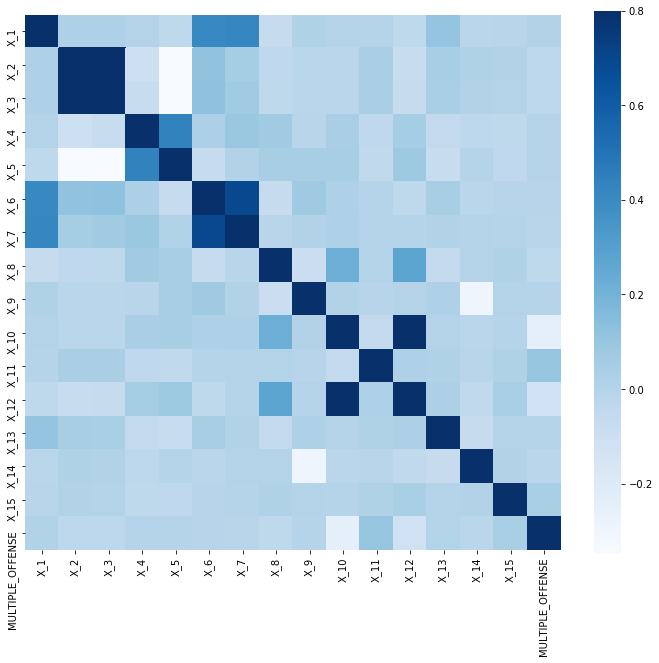

In [10]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, vmax=.8,cmap="Blues", square=True);

Correlation value for some combinations such as : 
1. X_2 and X_3
2. X_6 and X_7
3. X_10 and X_12

Hence it is much better to drop such columns as issue of multicollinearity may not let our predicting model to reach its full potential

In [11]:
# Dropping the collumns with very high correlation value
train.drop(['X_3','X_6','X_12'], axis = 1, inplace = True)
test.drop(['X_3','X_6','X_12'], axis = 1, inplace = True)

## Checking the test data

In [12]:
test.isna().sum()

INCIDENT_ID    0
DATE           0
X_1            0
X_2            0
X_4            0
X_5            0
X_7            0
X_8            0
X_9            0
X_10           0
X_11           0
X_13           0
X_14           0
X_15           0
dtype: int64

## Checking the target variable

In [13]:
train['MULTIPLE_OFFENSE'].value_counts()

1    22788
0     1068
Name: MULTIPLE_OFFENSE, dtype: int64

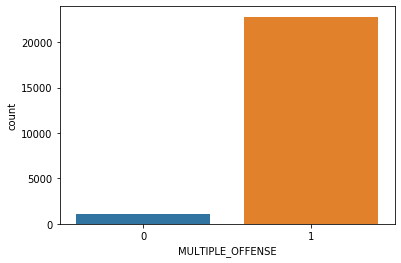

In [14]:
ax = sns.countplot(x="MULTIPLE_OFFENSE",data=train)

The target variable is highly biased and may cause problems in predicting the values, hence we should apply techniques like stratified sampling, SMOTE etc. for proper sampling in the training data

## Checking if there is any duplicate column present in the data

In [15]:
import tqdm
train_enc = pd.DataFrame(index = train.index)
for col in tqdm.tqdm_notebook(train.columns):
    train_enc[col] = train[col].factorize()[0]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


There are no duplicates in the given data

## Checking the skewness of the features given in the training set

In [16]:
feature_names = train.columns[2:]
feature_names

Index(['X_1', 'X_2', 'X_4', 'X_5', 'X_7', 'X_8', 'X_9', 'X_10', 'X_11', 'X_13',
       'X_14', 'X_15', 'MULTIPLE_OFFENSE'],
      dtype='object')

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:483: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  **kws)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:483: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  **kws)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:483: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  **kws)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:483: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  **kws)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:483: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  **kws)


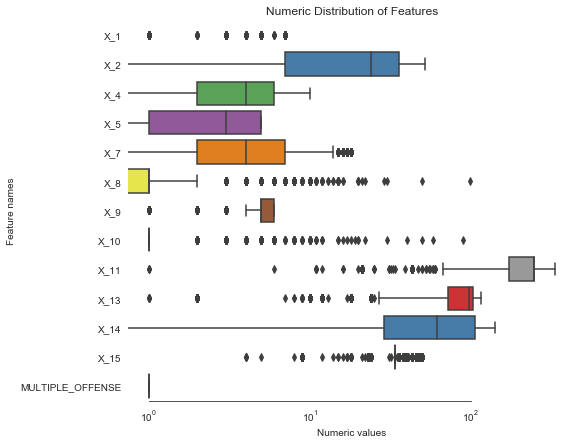

In [17]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=train[feature_names] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [18]:
# Find skewed numerical features
skew_features = train[feature_names].apply(lambda x: skew(x)).sort_values(ascending=False)

# Features with high skewness
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 4 numerical features with Skew > 0.5 :


X_10    34.940516
X_8     17.702736
X_1      3.789069
X_7      0.796118
X_14     0.245572
X_4      0.183382
X_5      0.175220
X_2     -0.094746
X_11    -0.903143
X_13    -1.388549
dtype: float64

In [19]:
# Normalize skewed features
for i in skew_index:
    train[i] = boxcox1p(train[i], boxcox_normmax(train[i] + 1))

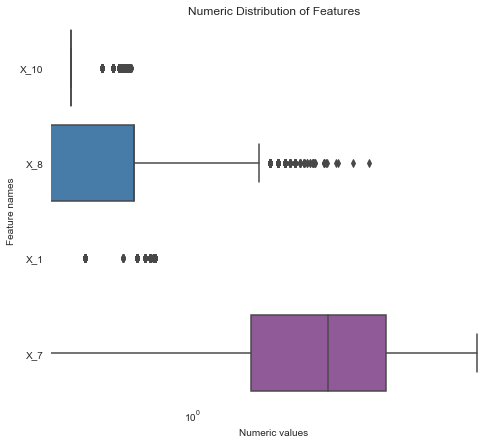

In [20]:
# Let's make sure we handled all the skewed values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=train[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

All the features look fairly normally distributed now.

## Checking Outliers in the data

In [21]:
# Dropping ID and target columns
z_score_calc = train.drop(columns=['INCIDENT_ID', 'DATE','MULTIPLE_OFFENSE'])
# Calculating z score
z = np.abs(stats.zscore(z_score_calc))
# print(z)
threshold = 3
print(np.where(z > 4))

(array([   96,   916,  1357,  1634,  1874,  2237,  2351,  2774,  3273,
        3479,  4133,  4413,  4438,  4606,  4616,  5091,  5299,  5540,
        5924,  6078,  6304,  6363,  6491,  6603,  6720,  6780,  7054,
        7054,  7621,  8001,  9026,  9150,  9510,  9573,  9690,  9729,
        9812, 10019, 10089, 10472, 11209, 11293, 11722, 12632, 12944,
       14270, 14335, 14352, 14475, 14755, 14870, 15186, 15295, 15472,
       15598, 15670, 15670, 15941, 16077, 16180, 16348, 16917, 17117,
       17263, 17361, 18001, 18640, 19151, 19229, 19346, 19349, 19456,
       19495, 19658, 20067, 20267, 20408, 20488, 20520, 20883, 21040,
       21731, 21881, 21881, 22540, 22999, 23376], dtype=int64), array([7, 7, 7, 7, 5, 7, 7, 7, 7, 5, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7, 5,
       7, 7, 7, 7, 5, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7,
       5, 7, 5, 7, 7, 5, 5, 7, 7, 5, 7, 5, 7, 7, 7, 7, 7, 5, 7, 7, 7, 5,
       7, 5, 7, 7, 5, 7, 7, 7, 7, 7, 5, 5, 5, 7, 5, 7, 5, 7, 7, 7, 5],
      dtype=int

In [22]:
treated_data = train[(z < 4).all(axis=1)]

In [23]:
print("before treating outliers : {}".format(train.shape))
print("after treating outliers : {}".format(treated_data.shape))

before treating outliers : (23856, 15)
after treating outliers : (23772, 15)


## Modelling

In [24]:
# Creating the variables for model fitting
X = treated_data.drop(columns=['INCIDENT_ID', 'DATE','MULTIPLE_OFFENSE'])
y = treated_data['MULTIPLE_OFFENSE']

# Test variable
test = test.drop(columns=['DATE','INCIDENT_ID'])

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .3, random_state=0)

In [26]:
!pip install imblearn

In [27]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 15908
Before OverSampling, counts of label '0': 732 

After OverSampling, the shape of train_X: (31816, 12)
After OverSampling, the shape of train_y: (31816,) 

After OverSampling, counts of label '1': 15908
After OverSampling, counts of label '0': 15908


In [28]:
## Import the random forest model.
from sklearn.ensemble import RandomForestClassifier
## This line instantiates the model. 
rf = RandomForestClassifier() 
## Fit the model on your training data.
rf.fit(X_train, y_train) 
## And score it on your testing data.
rf.score(X_test, y_test)

0.9948121144139092

In [29]:
## This line instantiates the model. 
rf2 = RandomForestClassifier() 
## Fit the model on your training data.
rf2.fit(X_train_res, y_train_res) 
## And score it on your testing data.
rf2.score(X_test, y_test)

0.9928491306786316

In [30]:
prediction_rf = rf.predict(test)

In [31]:
prediction_rf2 = rf2.predict(test)

In [32]:
# Filling the prediction values agains the Incident'id's of the test data 
# to create final submission file
test_orig = pd.read_csv("test.csv")
submission=pd.DataFrame({"INCIDENT_ID":test_orig['INCIDENT_ID'],
                         "MULTIPLE_OFFENSE":prediction_rf})

# Writing the submission dataframe to a csv file to submit
submission.to_csv('submission_rf.csv',index=False)

In [33]:
# Filling the prediction values agains the Incident'id's of the test data 
# to create final submission file
test_orig = pd.read_csv("test.csv")
submission=pd.DataFrame({"INCIDENT_ID":test_orig['INCIDENT_ID'],
                         "MULTIPLE_OFFENSE":prediction_rf2})

# Writing the submission dataframe to a csv file to submit
submission.to_csv('submission_rf2.csv',index=False)

In [34]:
!pip install lightgbm

In [35]:
import lightgbm as lgb
lgbc = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)
lgbc.fit(X_train, y_train) 
lgbc.score(X_test, y_test)

0.9976163768928772

In [36]:
lgbc2 = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)
lgbc2.fit(X_train_res, y_train_res) 
lgbc2.score(X_test, y_test)

0.9977565900168256

In [37]:
prediction_lgb = lgbc.predict(test)

In [38]:
prediction_lgbc2 = lgbc2.predict(test)

In [39]:
# Filling the prediction values agains the Incident'id's of the test data 
# to create final submission file
test_orig = pd.read_csv("test.csv")
submission=pd.DataFrame({"INCIDENT_ID":test_orig['INCIDENT_ID'],
                         "MULTIPLE_OFFENSE":prediction_lgb})

# Writing the submission dataframe to a csv file to submit
submission.to_csv('submission_lgb.csv',index=False)

In [40]:
# Filling the prediction values agains the Incident'id's of the test data 
# to create final submission file
test_orig = pd.read_csv("test.csv")
submission=pd.DataFrame({"INCIDENT_ID":test_orig['INCIDENT_ID'],
                         "MULTIPLE_OFFENSE":prediction_lgbc2})

# Writing the submission dataframe to a csv file to submit
submission.to_csv('submission_lgb2.csv',index=False)

In [41]:
!pip install xgboost

In [42]:
import xgboost as xgb
xgbc = xgb.XGBClassifier()
xgbc.fit(X_train, y_train) 
xgbc.score(X_test, y_test)

0.9990185081323611

In [43]:
prediction_xgb = xgbc.predict(test)

In [44]:
xgbc2 = xgb.XGBClassifier()
xgbc2.fit(X_train_res, y_train_res) 
xgbc2.score(X_test, y_test)

0.9987380818844643

In [45]:
prediction_xgb2 = xgbc2.predict(test)

In [46]:
# Filling the prediction values agains the Incident'id's of the test data 
# to create final submission file
test_orig = pd.read_csv("test.csv")
submission=pd.DataFrame({"INCIDENT_ID":test_orig['INCIDENT_ID'],
                         "MULTIPLE_OFFENSE":prediction_xgb})

# Writing the submission dataframe to a csv file to submit
submission.to_csv('submission_xgb.csv',index=False)

In [47]:
# Filling the prediction values agains the Incident'id's of the test data 
# to create final submission file
test_orig = pd.read_csv("test.csv")
submission=pd.DataFrame({"INCIDENT_ID":test_orig['INCIDENT_ID'],
                         "MULTIPLE_OFFENSE":prediction_xgb2})

# Writing the submission dataframe to a csv file to submit
submission.to_csv('submission_xgb2.csv',index=False)

In [48]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return (((0.1 * rf.predict(X)) + \
            (0.1 * lgbc.predict(X)) + \
            (0.15 * lgbc2.predict(X)) + \
            (0.2 * xgbc.predict(X)) + \
            (0.35 * xgbc2.predict((X)))))

In [49]:
final_predictions  = blended_predictions(test)

In [50]:
final_predictions

array([0.2, 0.9, 0.9, ..., 0.9, 0.9, 0.9])

In [51]:
# Filling the prediction values agains the Incident'id's of the test data 
# to create final submission file
test_orig = pd.read_csv("test.csv")
submission=pd.DataFrame({"INCIDENT_ID":test_orig['INCIDENT_ID'],
                         "MULTIPLE_OFFENSE":final_predictions})

# Writing the submission dataframe to a csv file to submit
submission.to_csv('submission_final.csv',index=False)